# From Soladity to bytes, bytes to opcodes.

2024-12-10 18:29:46,904 - INFO - 
Compilation Summary:
2024-12-10 18:29:46,906 - INFO - Total contracts: 0
2024-12-10 18:29:46,908 - INFO - Successfully compiled: 0
2024-12-10 18:29:46,910 - INFO - Failed to compile: 0


In [13]:
sol_dir = Path('./Dataset')
compiler = SolidityCompiler()
compiler.compile_all(sol_dir)
    
        
        

# Load data

In [18]:
import os
import json
import pandas as pd

DATAPATH = "./OutputOpcodes"
data_list = []

for file in os.listdir(DATAPATH):
    if file.endswith(".json"):
        with open(os.path.join(DATAPATH, file), 'r') as f:
            data = json.load(f)
            opcodes = data["opcodes"]
            # Append a dictionary with file name and opcodes to the list
            data_list.append({"file_name": file.split("_")[0], "opcodes": opcodes})

# Create a DataFrame from the list of dictionaries
data = pd.DataFrame(data_list)
data

,file_name,opcodes
0,AIChain,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
1,ERC20Token,[]
2,UTBTokenTest,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
3,CorelliCoin,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
4,limitedFactor,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
...,...,...
747,GATcoin,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
748,PylonToken,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, MLOAD, SW..."
749,AbstractToken,[]
750,State,[]


# EDA

In [19]:
empty_opcode_count = len(data[data['opcodes'].apply(lambda x: len(x) == 0)])
print(f"Number of rows with empty opcodes: {empty_opcode_count}")



Number of rows with empty opcodes: 145


In [20]:
# Remove all null 
data = data[data['opcodes'].apply(lambda x: len(x) > 0)]
empty_opcode_count = len(data[data['opcodes'].apply(lambda x: len(x) == 0)])
print(f"Number of rows with empty opcodes: {empty_opcode_count}")


Number of rows with empty opcodes: 0


In [21]:
data

,file_name,opcodes
0,AIChain,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
2,UTBTokenTest,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
3,CorelliCoin,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
4,limitedFactor,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
5,BitStore,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
...,...,...
745,ObjectToken,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, MLOAD, SW..."
746,CloutToken,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, SSTORE, P..."
747,GATcoin,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, PUSH1, PU..."
748,PylonToken,"[PUSH1, PUSH1, MSTORE, PUSH1, PUSH1, MLOAD, SW..."


INFO:root:Analyzing contract AIChain...
INFO:root:Analyzing contract UTBTokenTest...
INFO:root:Analyzing contract CorelliCoin...
INFO:root:Analyzing contract limitedFactor...
INFO:root:Analyzing contract BitStore...
INFO:root:Analyzing contract MerkleProof...
INFO:root:Analyzing contract BitAseanToken...
INFO:root:Analyzing contract EastcoinToken...
INFO:root:Analyzing contract Multiownable...
INFO:root:Analyzing contract CardFactory...
INFO:root:Analyzing contract TheGoDigital...
INFO:root:Analyzing contract MVGcoin...
INFO:root:Analyzing contract ClaimableOwnable...
INFO:root:Analyzing contract Virgo...
INFO:root:Analyzing contract SimplePriceOracle...
INFO:root:Analyzing contract SendMe...
INFO:root:Analyzing contract Controlled...
INFO:root:Analyzing contract BasicToken...
INFO:root:Analyzing contract admined...
INFO:root:Analyzing contract JPMD100B...
INFO:root:Analyzing contract CErc20...
INFO:root:Analyzing contract TestRegistry...
INFO:root:Analyzing contract ProjectJ...
INFO:r


Vulnerability Analysis Summary:
--------------------------------------------------
Total contracts analyzed: 607

Vulnerability Statistics:
Reentrancy Risk: 438 contracts (72.16%)
Integer Overflow Risk: 3 contracts (0.49%)
Gas Limit Risk: 543 contracts (89.46%)

Example Contracts with Vulnerabilities:
--------------------------------------------------
       file_name  reentrancy_risk  integer_overflow_risk  gas_limit_risk
0        AIChain             True                  False            True
1   UTBTokenTest             True                  False            True
2    CorelliCoin             True                  False            True
3  limitedFactor            False                  False            True
4       BitStore             True                  False            True


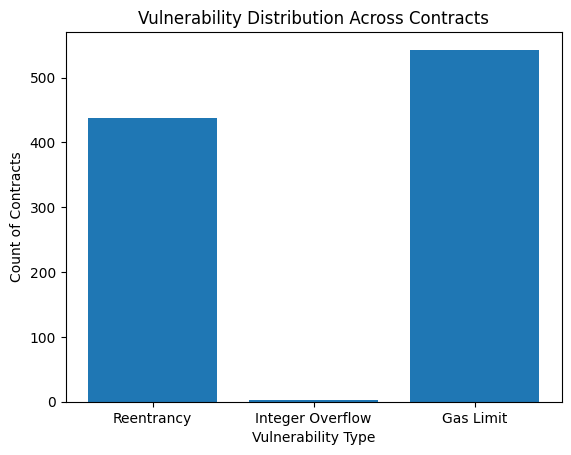

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

def analyze_contract_vulnerabilities(opcodes_list):
    if not opcodes_list:
        return {'reentrancy_risk': False, 'integer_overflow_risk': False, 'gas_limit_risk': False}

    # Set up the relevant opcodes
    external_calls = {'CALL', 'CALLCODE', 'DELEGATECALL', 'STATICCALL'}
    state_changes = {'SSTORE', 'MSTORE'}
    arithmetic_ops = {'ADD', 'SUB', 'MUL', 'DIV', 'SDIV'}
    safety_ops = {'GT', 'LT', 'ISZERO'}  # Safety checks to prevent overflows
    loop_opcodes = {'JUMP', 'JUMPI'}
    dangerous_opcodes = {'SLOAD', 'SSTORE', 'CALL', 'DELEGATECALL'}

    def check_reentrancy(opcodes):
        # Check for external calls followed by state changes
        for i, opcode in enumerate(opcodes):
            if opcode in external_calls:
                # Check if any state-changing operation follows the external call
                if any(op in state_changes for op in opcodes[i:]):
                    return True
        return False

    def check_integer_overflow(opcodes):
        # Look for arithmetic operations without proper safety checks
        has_arithmetic = False
        has_safety_check = False

        for opcode in opcodes:
            if opcode in arithmetic_ops:
                has_arithmetic = True
            if opcode in safety_ops:
                has_safety_check = True
        
        # Integer overflow risk if there is arithmetic but no safety checks
        return has_arithmetic and not has_safety_check

    def check_gas_limit(opcodes):
        # Check for unbounded loops and high gas-cost operations
        loop_count = sum(1 for op in opcodes if op in loop_opcodes)
        expensive_ops = sum(1 for op in opcodes if op in dangerous_opcodes)

        # Return True if there are loops and more than 5 expensive operations
        return loop_count > 0 and expensive_ops > 5

    # Results dictionary to store the risk for each vulnerability
    results = {
        'reentrancy_risk': check_reentrancy(opcodes_list),
        'integer_overflow_risk': check_integer_overflow(opcodes_list),
        'gas_limit_risk': check_gas_limit(opcodes_list)
    }

    return results


def analyze_all_contracts(df):
    # Analyze all contracts in the provided DataFrame
    results = []
    for _, row in df.iterrows():
        logging.info(f"Analyzing contract {row['file_name']}...")
        # Perform vulnerability analysis on each contract's opcodes
        analysis = analyze_contract_vulnerabilities(row['opcodes'])
        analysis['file_name'] = row['file_name']
        results.append(analysis)
    
    # Return the analysis results as a DataFrame
    return pd.DataFrame(results)


# # Example usage
# data = pd.DataFrame({
#     'file_name': ['contract_1', 'contract_2', 'contract_3'],
#     'opcodes': [
#         ['CALL', 'SSTORE', 'MSTORE', 'ADD', 'DIV'],  # contract_1: Reentrancy Risk
#         ['ADD', 'SUB', 'MUL', 'DIV', 'SSTORE'],  # contract_2: Integer Overflow Risk
#         ['JUMP', 'JUMPI', 'SSTORE', 'CALL', 'DELEGATECALL', 'SLOAD', 'SSTORE']  # contract_3: Gas Limit Risk
#     ]
# })

vulnerability_analysis = analyze_all_contracts(data)

print("\nVulnerability Analysis Summary:")
print("-" * 50)
print(f"Total contracts analyzed: {len(vulnerability_analysis)}")
print("\nVulnerability Statistics:")
for col in ['reentrancy_risk', 'integer_overflow_risk', 'gas_limit_risk']:
    vulnerable_count = vulnerability_analysis[col].sum()
    percentage = (vulnerable_count / len(vulnerability_analysis)) * 100
    print(f"{col.replace('_', ' ').title()}: {vulnerable_count} contracts ({percentage:.2f}%)")

data_with_analysis = data.merge(vulnerability_analysis, on='file_name')

print("\nExample Contracts with Vulnerabilities:")
print("-" * 50)
vulnerable_contracts = data_with_analysis[
    (data_with_analysis['reentrancy_risk']) | 
    (data_with_analysis['integer_overflow_risk']) | 
    (data_with_analysis['gas_limit_risk'])
].head()

print(vulnerable_contracts[['file_name', 'reentrancy_risk', 'integer_overflow_risk', 'gas_limit_risk']])

# Plotting the distribution of vulnerabilities
vulnerability_counts = [
    vulnerability_analysis['reentrancy_risk'].sum(),
    vulnerability_analysis['integer_overflow_risk'].sum(),
    vulnerability_analysis['gas_limit_risk'].sum()
]
vulnerability_labels = ['Reentrancy', 'Integer Overflow', 'Gas Limit']

plt.bar(vulnerability_labels, vulnerability_counts)
plt.title('Vulnerability Distribution Across Contracts')
plt.xlabel('Vulnerability Type')
plt.ylabel('Count of Contracts')
plt.show()


# Preprocessing

# Modeling